In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.cluster import AgglomerativeClustering

In [3]:
%load_ext autoreload
%autoreload 2

from src.preprocess_lib import *

In [4]:
def kl_div_dirichlet(alpha_1, alpha_2):
    return sp.special.gammaln(np.sum(alpha_1,axis=1)) - np.sum(sp.special.gammaln(alpha_1),axis=1) - sp.special.gammaln(np.sum(alpha_2, axis=1)) + np.sum(sp.special.gammaln(alpha_2),axis=1) + np.sum((alpha_1-alpha_2)*(sp.special.digamma(alpha_1)-sp.special.digamma(np.sum(alpha_1, axis=1))[:,np.newaxis]),axis=1)

def sym_kl_div_dirichlet(alpha_1, alpha_2):
    return 0.5*(kl_div_dirichlet(alpha_1, alpha_2) + kl_div_dirichlet(alpha_2, alpha_1))

In [5]:
dataset_dir = "/home/kbolat/Python/behavio-temporal-vae/data"
dataset_name = "goi4_dp_full_Gipuzkoa/"

In [6]:
alphas = np.load(os.path.join(dataset_dir, dataset_name, "user_encoding_models/model_11/user_gamma.npy"))
num_users, n_dims = alphas.shape

In [7]:
X, _ = get_full_data(dataset_dir, dataset_name)
X = X.reshape(num_users, -1)

Dataset: goi4_dp_full_Gipuzkoa/
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


In [8]:
distances = sym_kl_div_dirichlet(alphas[:,:,None], alphas.T[None,:,:])

In [9]:
num_stereotypes = 20

clustering = AgglomerativeClustering(n_clusters=num_stereotypes, metric="precomputed", linkage="average", compute_distances=True).fit(distances)
labels = clustering.labels_

In [10]:
stereotypes = np.zeros((num_stereotypes, n_dims))
for stereotype_no in range(num_stereotypes):
    stereotype = np.mean(alphas[labels==stereotype_no], axis=0)
    stereotypes[stereotype_no] = stereotype

In [11]:
num_representatives = 3
users_stereotyped = np.zeros((num_users, n_dims))
representatives = np.zeros((num_stereotypes, num_representatives ), dtype=int)
representative_distances  = np.ones((num_stereotypes, num_representatives ))*np.inf
for user_no in range(num_users): 
    users_stereotyped[user_no] = stereotypes[labels[user_no]]
    distance = sym_kl_div_dirichlet(stereotypes[[labels[user_no]]], alphas[[user_no]])[0]
    if distance < np.max(representative_distances[labels[user_no]]):
        representative_distances[labels[user_no]][np.argmax(representative_distances[labels[user_no]])] = distance
        representatives[labels[user_no]][np.argmax(representative_distances[labels[user_no]])] = user_no

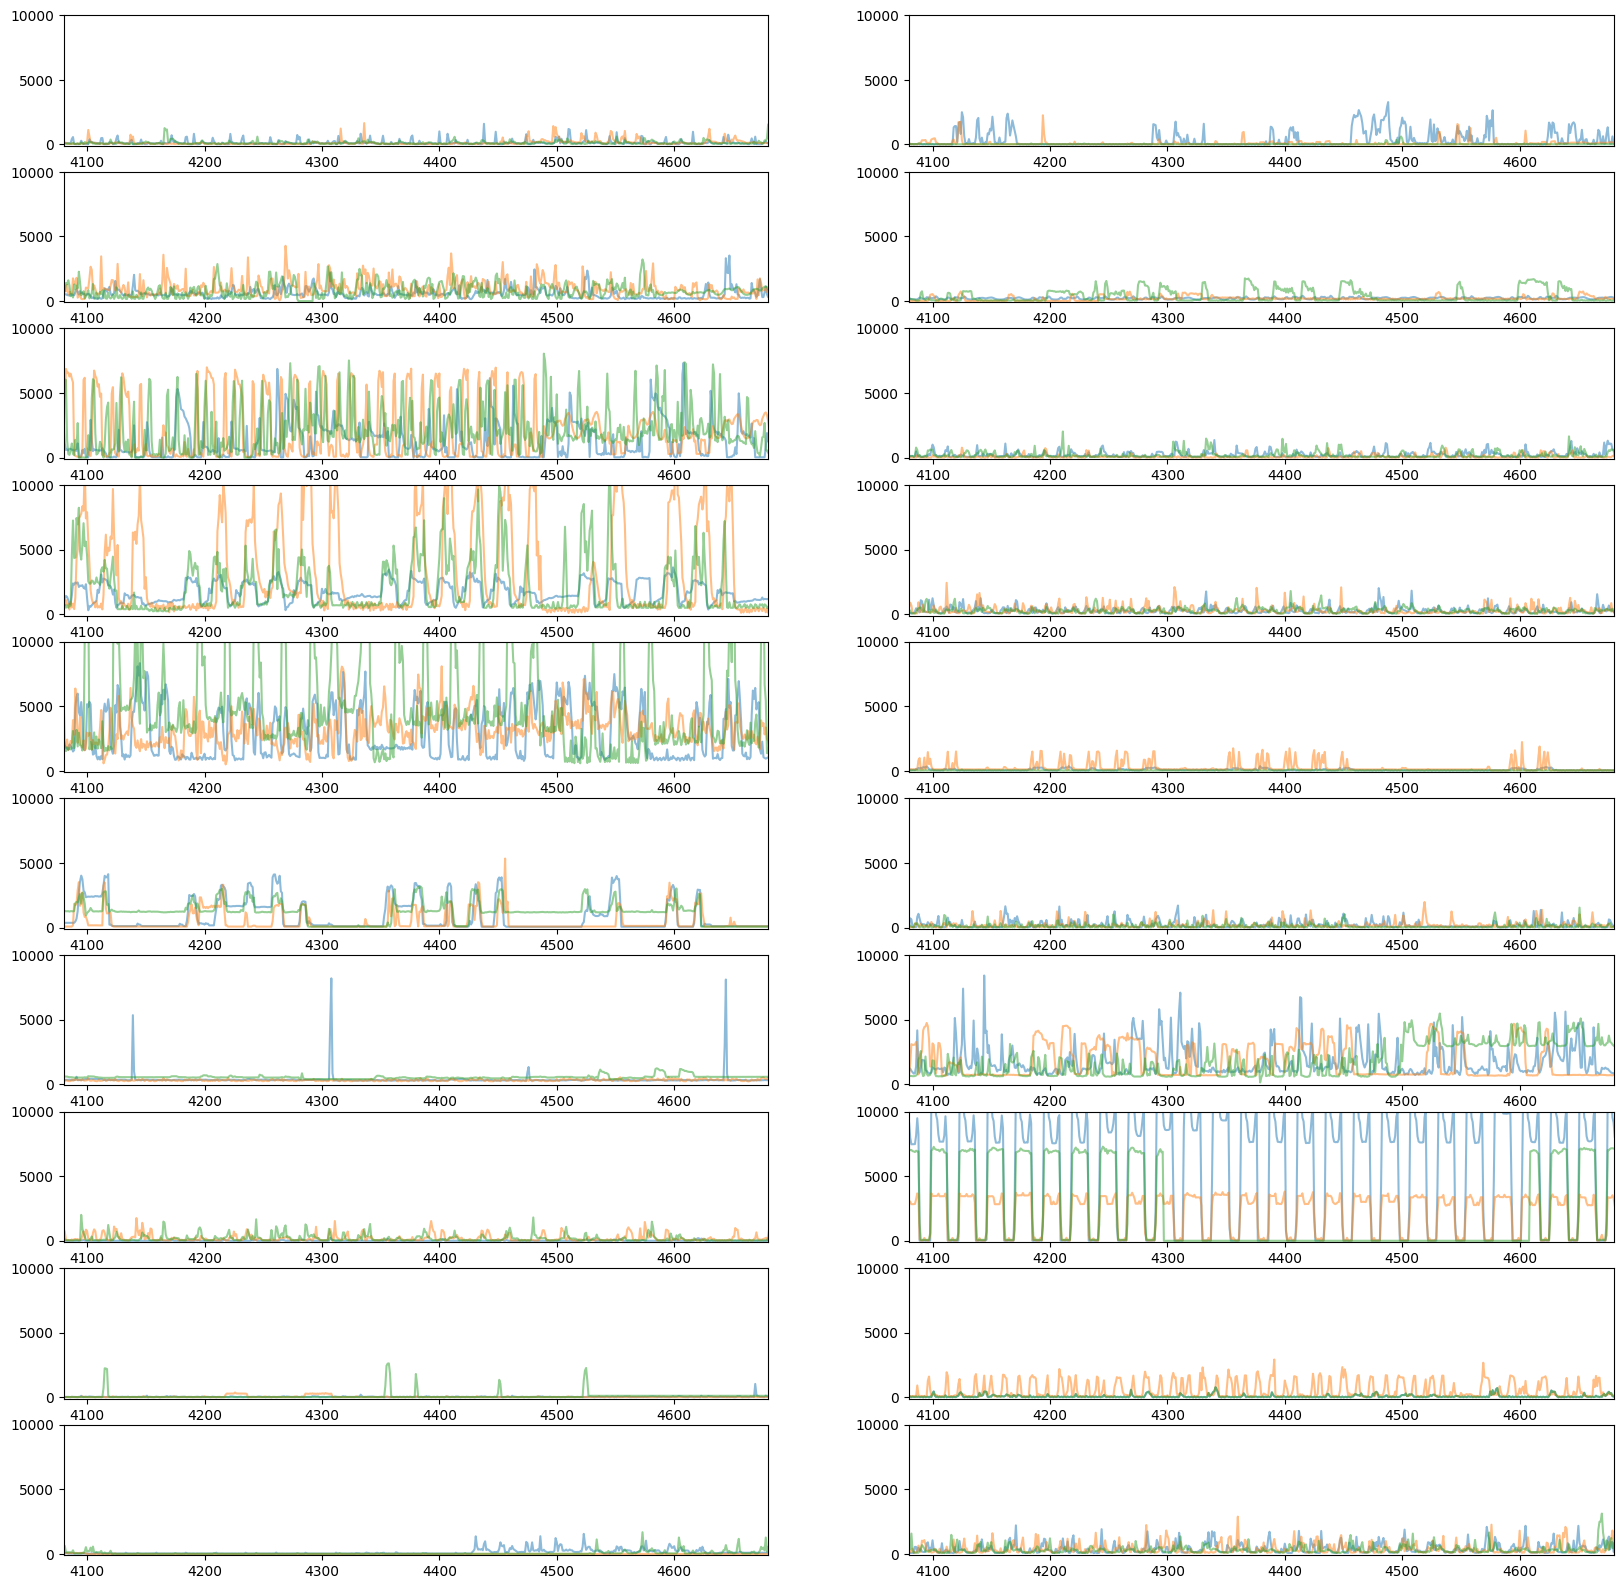

In [12]:
fig, ax = plt.subplots(num_stereotypes//2, 2, figsize=(20, 20))

for stereotype_no in range(num_stereotypes):
    ax[stereotype_no//2, stereotype_no%2].plot(X[representatives[stereotype_no]].T, alpha=0.5)
    ax[stereotype_no//2, stereotype_no%2].set_xlim(X.shape[1]//2-300, X.shape[1]//2+300)
    ax[stereotype_no//2, stereotype_no%2].set_ylim(-100, 10000)


In [13]:
stereo_distances = sym_kl_div_dirichlet(stereotypes[:,:,None], stereotypes.T[None,:,:])

In [14]:
## find closest neighbor
closest_neighbor_str = np.zeros(num_stereotypes, dtype=int)
closest_distances_str = np.zeros(num_stereotypes)
stereo_distances_ = stereo_distances.copy()
for stereotype in range(num_stereotypes):
    stereo_distances_[stereotype, stereotype] = np.nan
    closest_neighbor_str[stereotype] = np.nanargmin(stereo_distances_[stereotype])
    closest_distances_str[stereotype] = stereo_distances_[stereotype, closest_neighbor_str[stereotype]]

In [15]:
eps = 0.05
interpolation_degrees = (.5-eps) * ( (np.log(closest_distances_str) - np.min(np.log(closest_distances_str))) / (np.max(np.log(closest_distances_str)) - np.min(np.log(closest_distances_str)))) + (eps)
stereotype_interpolates = np.zeros((num_stereotypes, n_dims))
for stereotype in range(num_stereotypes):
    stereotype_interpolates[stereotype] = (1-interpolation_degrees[stereotype])*stereotypes[stereotype] + interpolation_degrees[stereotype]*stereotypes[closest_neighbor_str[stereotype]]

In [16]:
users_stereotyped_interpolated = np.zeros((num_users, n_dims))
for user_no in range(num_users): users_stereotyped_interpolated[user_no] = stereotype_interpolates[labels[user_no]]

In [17]:
ssample = 20## for visualization

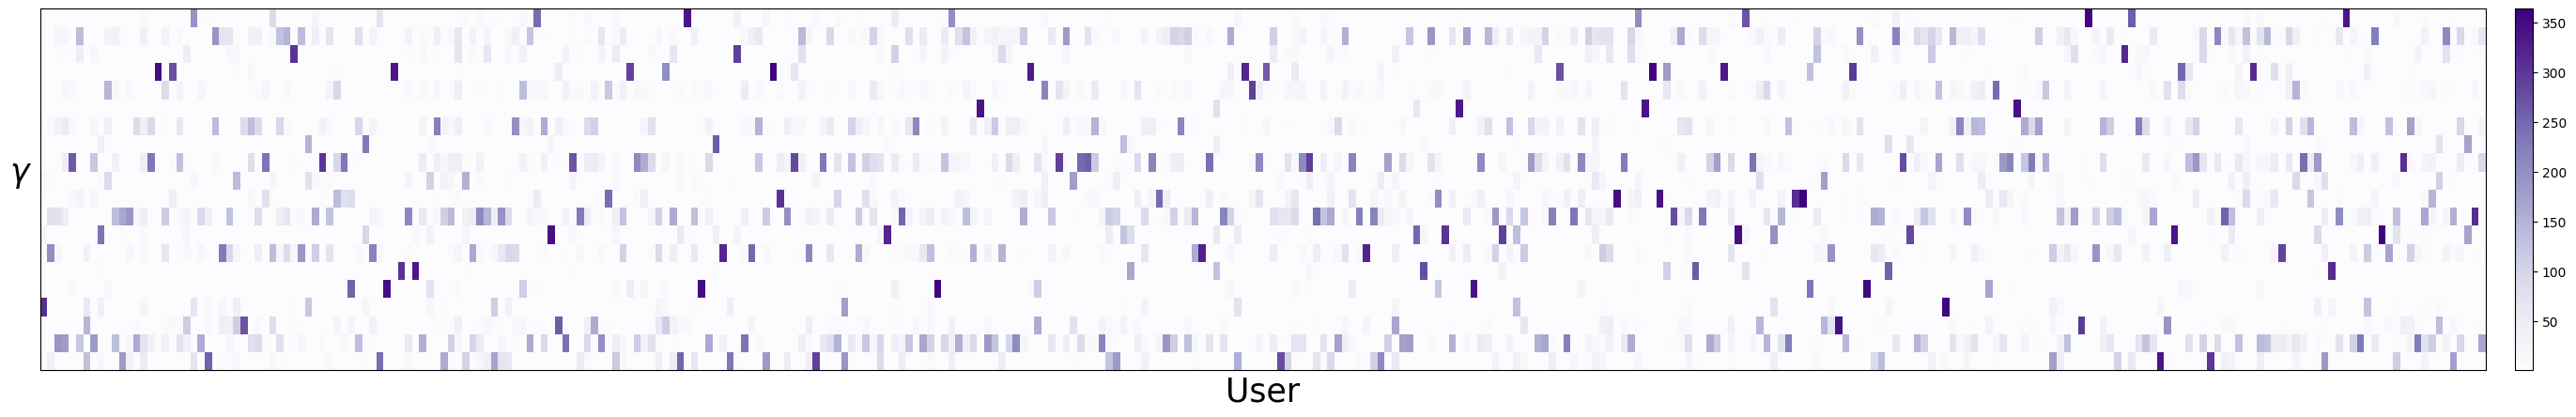

In [18]:
fig, ax = plt.subplots(figsize=(40, 5))
plt.pcolormesh(alphas[9::ssample].T, cmap='Purples')
ax.set_xlabel("User", size=25)
ax.set_ylabel(r"$\gamma$", size=25, rotation=0, labelpad=15)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad=0.01)

plt.show()

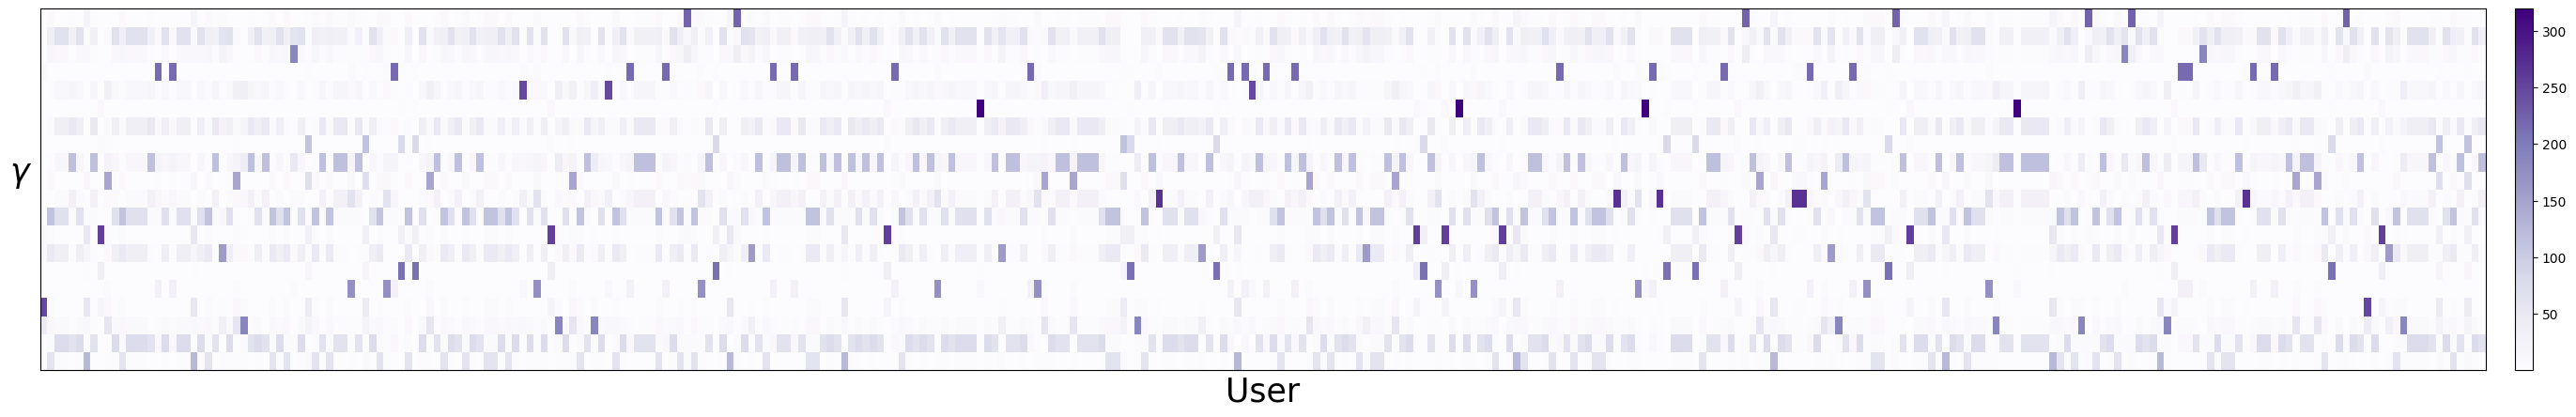

In [19]:
fig, ax = plt.subplots(figsize=(40, 5))
plt.pcolormesh(users_stereotyped[9::ssample].T, cmap='Purples')
ax.set_xlabel("User", size=25)
ax.set_ylabel(r"$\gamma$", size=25, rotation=0, labelpad=15)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad=0.01)

plt.show()

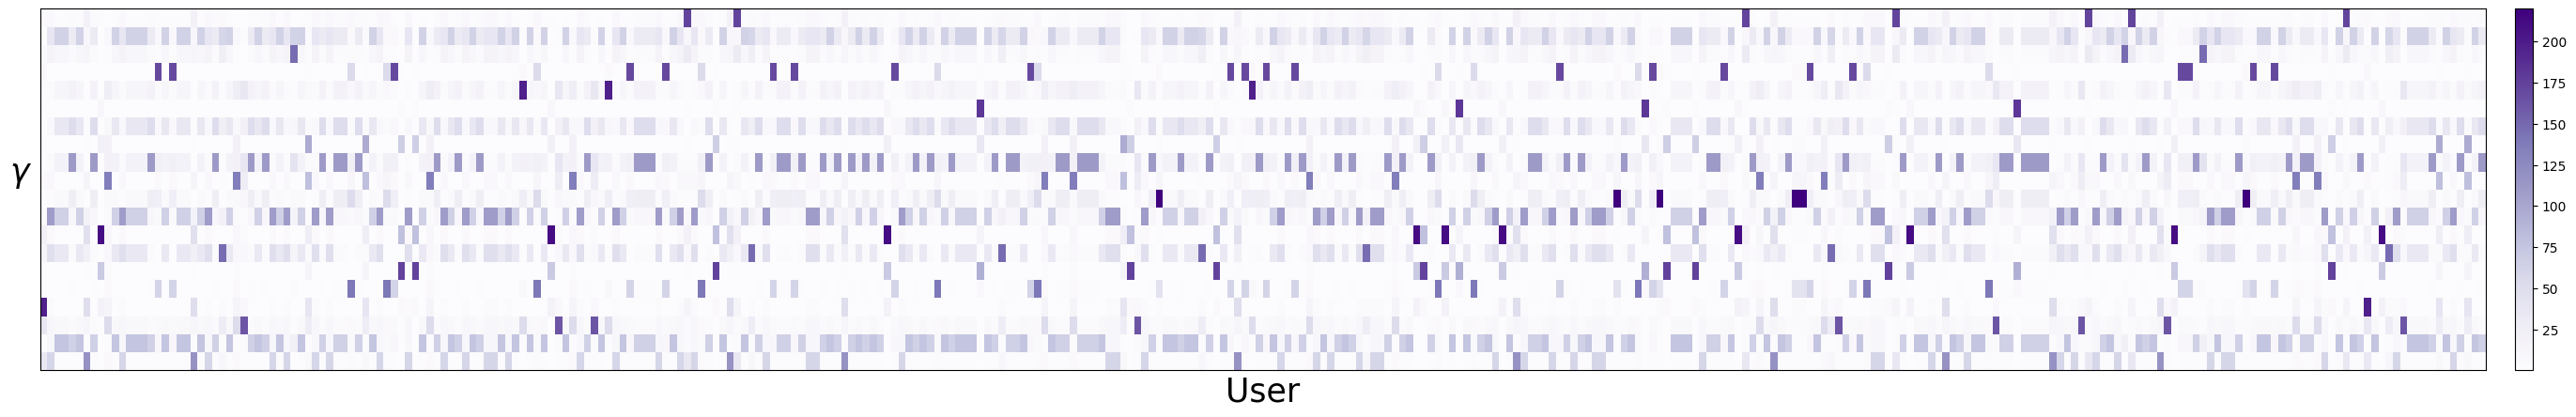

In [20]:
fig, ax = plt.subplots(figsize=(40, 5))
plt.pcolormesh(users_stereotyped_interpolated[9::ssample].T, cmap='Purples')
ax.set_xlabel("User", size=25)
ax.set_ylabel(r"$\gamma$", size=25, rotation=0, labelpad=15)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad=0.01)

plt.show()

In [21]:
rnd_user_idx = np.random.randint(0, num_users)

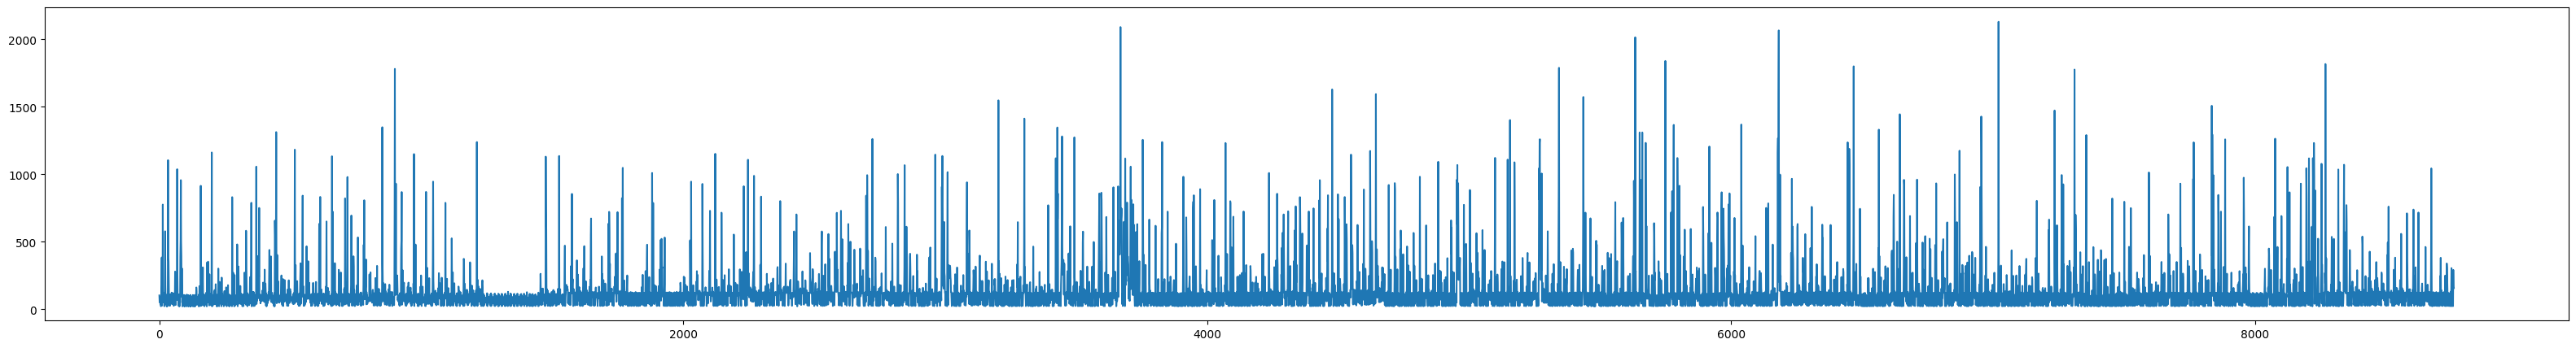

In [22]:
fig, ax = plt.subplots(figsize=(40, 5))

plt.plot(X[rnd_user_idx])

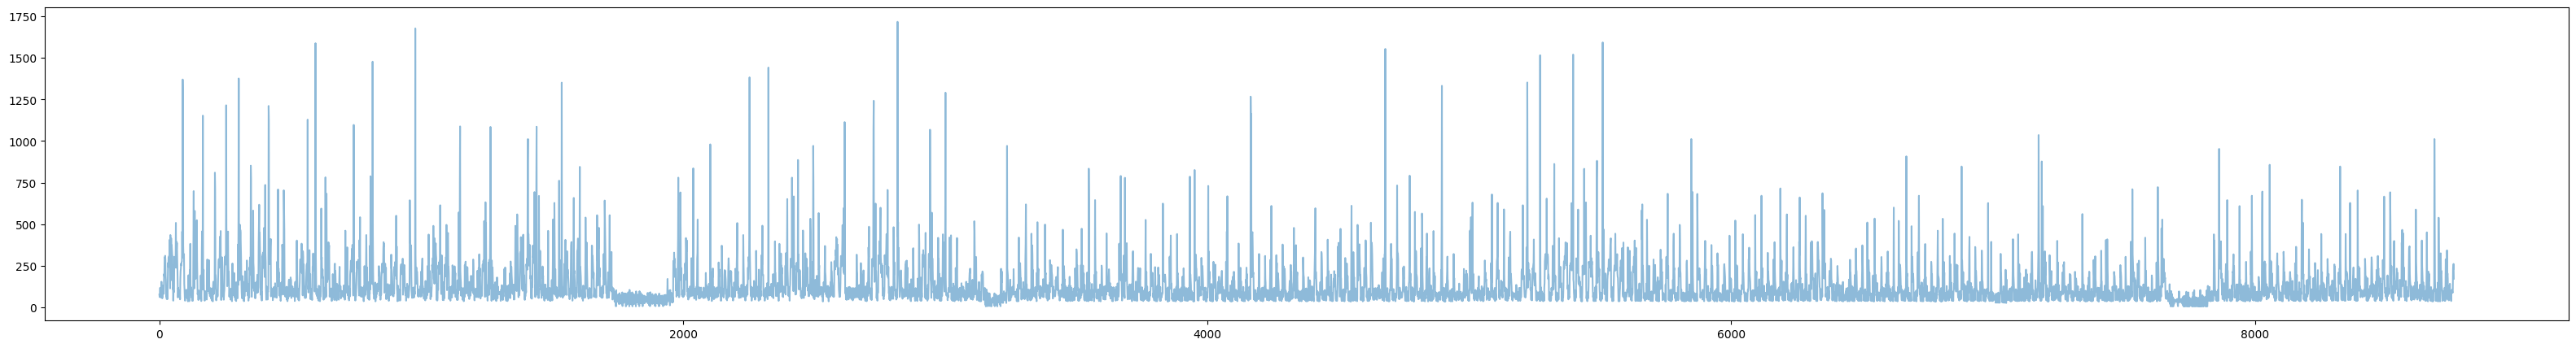

In [23]:
fig, ax = plt.subplots(figsize=(40, 5))

plt.plot(X[representatives[labels[rnd_user_idx]][2]].T, alpha=0.5)